In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import math
plt.style.use(style='ggplot')
plt.rcParams['figure.figsize'] = (10, 6)

In [ ]:
from scipy.stats import uniform
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import SGDRegressor, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from lightgbm import LGBMRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

# Load Data from Kaggle

Load data to Colab from Kaggle using Kaggle API without uploading it localy. 

In [ ]:
# ! pip install -q kaggle

From Kaggle -> Account: Download a Kaggle.JSON File from this button: 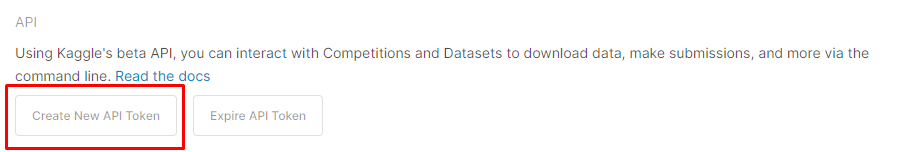

and upload the file in the next cell.
You must upload the file everytime you reset the session.

In [ ]:
# from google.colab import files
# files.upload() #upload kaggle.json

In [ ]:
# !mkdir -p ~/.kaggle

In [ ]:
# !cp kaggle.json ~/.kaggle/

In [ ]:
# # change the file permissions
# ! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# # updating kaggle api
# !pip install --upgrade --force-reinstall --no-deps kaggle

In [ ]:
# ! kaggle competitions download -c ashrae-energy-prediction

In [ ]:
# #unzipping the zip files and deleting the zip files
# !unzip \*.zip  && rm *.zip

# Loading Data

In [ ]:
# load train and test data

# Kaggle
train = pd.read_csv('../input/ashrae-energy-prediction/train.csv', parse_dates=['timestamp'], infer_datetime_format=True)
test = pd.read_csv('../input/ashrae-energy-prediction/test.csv', parse_dates=['timestamp'], infer_datetime_format=True)

# Colab
# train = pd.read_csv('/content/train.csv', parse_dates=['timestamp'], infer_datetime_format=True)
# test = pd.read_csv('/content/test.csv', parse_dates=['timestamp'], infer_datetime_format=True)

In [ ]:
train.info()

In [ ]:
# load weather data
# Kaggle
weather_train = pd.read_csv('../input/ashrae-energy-prediction/weather_train.csv', parse_dates=['timestamp'], infer_datetime_format=True)
weather_test = pd.read_csv('../input/ashrae-energy-prediction/weather_test.csv', parse_dates=['timestamp'], infer_datetime_format=True)

# Colab
# weather_train = pd.read_csv('/content/weather_train.csv', parse_dates=['timestamp'], infer_datetime_format=True)
# weather_test = pd.read_csv('/content/weather_test.csv', parse_dates=['timestamp'], infer_datetime_format=True)

In [ ]:
weather_train.info()

In [ ]:
#load Buildings data
# Kaggle
building = pd.read_csv('../input/ashrae-energy-prediction/building_metadata.csv')

# Colab
# building = pd.read_csv('/content/building_metadata.csv')

In [ ]:
building.info()

# Reducing Memory Usage

In [ ]:
## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [ ]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

weather_train = reduce_mem_usage(weather_train)
weather_test = reduce_mem_usage(weather_test)
building = reduce_mem_usage(building)

# Weather Data Imputation

In [ ]:
# get cloumns that have null in train data
missing_cols = [col for col in weather_train.columns if weather_train[col].isna().any()] 

# stores the mean of each feature for each site id
fill_lib = weather_train.groupby('site_id')[missing_cols].transform('mean') 

# for each feature with missing values, fill the missing entry with the mean for that site
weather_train.fillna(fill_lib, inplace=True)

In [ ]:
# get cloumns that have null in test data
missing_cols = [col for col in weather_test.columns if weather_test[col].isna().any()]

# stores the mean of each feature for each site id
fill_lib = weather_test.groupby('site_id')[missing_cols].transform('mean')

# for each feature with missing values, fill the missing entry with the mean for that site
weather_test.fillna(fill_lib, inplace=True)

### Merge datasets with train and test

Merge the three datasets in one Dataframe

In [ ]:
train = train.merge(building, on = 'building_id', how = 'left')
test = test.merge(building, on = 'building_id', how = 'left')

In [ ]:
train = train.merge(weather_train, on = ['site_id', 'timestamp'], how = 'left')
test = test.merge(weather_test, on = ['site_id', 'timestamp'], how = 'left')

In [ ]:
# delete non-used variables to free some memory 
del weather_train, weather_test, building
gc.collect()

In [ ]:
print('train shape: ', train.shape)
print('test shape:  ', test.shape)

In [ ]:
train.info()

# Data Imputation

In [ ]:
train.isna().sum() / len(train)

**drop columns that have lots of nulls**

In [ ]:
train.drop(['year_built', 'floor_count', 'cloud_coverage'], axis='columns', inplace=True)
test.drop(['year_built', 'floor_count', 'cloud_coverage'], axis='columns', inplace=True)

train.columns

In [ ]:
# check columns that have nulls
train.isna().sum() / len(train)

In [ ]:
test.isna().sum() / len(test)

In [ ]:
train_viz = train.sample(10000)

# Exploratory Data Analysis

In [ ]:
sns.displot(train_viz['air_temperature'], kde=True)

In [ ]:
train['air_temperature'].fillna(value=train['air_temperature'].median(), inplace=True)
test['air_temperature'].fillna(value=train['air_temperature'].median(), inplace=True)

In [ ]:
sns.displot(train_viz['dew_temperature'], kde=True)

In [ ]:
train['dew_temperature'].fillna(value=train['dew_temperature'].median(), inplace=True)
test['dew_temperature'].fillna(value=train['dew_temperature'].median(), inplace=True)

In [ ]:
sns.displot(train_viz['precip_depth_1_hr'], kde=True)

In [ ]:
train['precip_depth_1_hr'].fillna(value=train['precip_depth_1_hr'].median(), inplace=True)
test['precip_depth_1_hr'].fillna(value=train['precip_depth_1_hr'].median(), inplace=True)

In [ ]:
sns.displot(train_viz['sea_level_pressure'], kde=True) 

In [ ]:
train['sea_level_pressure'].fillna(value=train['sea_level_pressure'].median(), inplace=True)
test['sea_level_pressure'].fillna(value=train['sea_level_pressure'].median(), inplace=True)

In [ ]:
sns.displot(train_viz['wind_direction'], kde=True)

In [ ]:
train['wind_direction'].fillna(value=train['wind_direction'].median(), inplace=True)
test['wind_direction'].fillna(value=train['wind_direction'].median(), inplace=True)

In [ ]:
sns.displot(train_viz['wind_speed'], kde=True)

In [ ]:
train['wind_speed'].fillna(value=train['wind_speed'].median(), inplace=True)
test['wind_speed'].fillna(value=train['wind_speed'].median(), inplace=True)

In [ ]:
# check if there are any variables that still have nulls
train.isna().sum() / len(train)

In [ ]:
test.isna().sum() / len(test)

In [ ]:
train['site_id'] = train['site_id'].astype(object)

In [ ]:
train['site_id'].value_counts(normalize=True).plot(kind='bar')

# Correlation Analysis

Check the correlation between numerical variables

In [ ]:
corr = train_viz.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, cmap='YlGnBu', annot=True)

From the heatmap we can see that dew_temperature and air_temperature have strong correlation, so we will drop dew_temperature from the data.

In [ ]:
train.drop(['dew_temperature'], axis='columns', inplace=True)
test.drop(['dew_temperature'], axis='columns', inplace=True)

In [ ]:
# drop building_id from dataset
test_ids = test['building_id']
train.drop(['building_id'], axis='columns', inplace=True)
test.drop(['building_id'], axis='columns', inplace=True)

## Target Variable Analysis

In [ ]:
print ("Skew is:", train.meter_reading.skew())
sns.displot(train.meter_reading.sample(1000), kde=True )
plt.show()

In [ ]:
train['meter_reading'] = np.log(train['meter_reading']+1)
# train['meter_reading'] = np.expm1(train['meter_reading'])

In [ ]:
print ("Skew is:", train.meter_reading.skew())
sns.displot(train.meter_reading.sample(1000), kde=True)
plt.show()

Now lets explore outliers in the Target Variable

In [ ]:
sns.boxplot(x = train['meter_reading'])

In [ ]:
train = train[train['meter_reading'] <= 10]

In [ ]:
sns.boxplot(x = train['meter_reading'])

In [ ]:
train.info()

# Feature Engineering

In [ ]:
train['timestamp']

In [ ]:
# extract more data from timestamp
train['year'] = train['timestamp'].dt.year
train['month'] = train['timestamp'].dt.month
train['day'] = train['timestamp'].dt.day
train['hour'] = train['timestamp'].dt.hour

In [ ]:
# extract more data from timestamp
test['year'] = test['timestamp'].dt.year
test['month'] = test['timestamp'].dt.month
test['day'] = test['timestamp'].dt.day
test['hour'] = test['timestamp'].dt.hour

In [ ]:
# drop timestamp column
train.drop(['timestamp'], axis='columns', inplace=True)

In [ ]:
test.drop(['timestamp'], axis='columns', inplace=True)

# Data Preprocessing

## Label Encoding

Apply label encoding on categorical variables.

In [ ]:
le = LabelEncoder()
categorical_cols = list(train.select_dtypes(include=object))
train[categorical_cols] = train[categorical_cols].apply(le.fit_transform)
train[categorical_cols]

In [ ]:
categorical_cols = list(test.select_dtypes(include=object))
test[categorical_cols] = test[categorical_cols].apply(le.fit_transform)
test[categorical_cols]

## Train Test Split

Split the train data to train and test data, 75% Train and 25% Test.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train.drop(['meter_reading'],
                                  axis='columns'), train['meter_reading'],
                                  test_size=0.25, random_state=0)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

In [ ]:
X_train = reduce_mem_usage(X_train)
X_test = reduce_mem_usage(X_test)

## Feature Scaling

Scale the numerical variables for better results on regression models.

In [ ]:
ssc = StandardScaler()
ssc.fit(X_train)
X_train = ssc.transform(X_train)
X_test = ssc.transform(X_test)

In [ ]:
# delete non-used variables to free some memory 
# del ssc
gc.collect()

# Modeling

## Comparing Models

In [ ]:
sgdreg = SGDRegressor()
sgdreg.fit(X_train, y_train)
y_pred = sgdreg.predict(X_test)
print("RMSLE for Stochastic Gradient Descent: ", math.sqrt(mean_squared_error(y_test, y_pred)))

In [ ]:
# del sgdreg, y_pred
# gc.collect()

In [ ]:
ridgereg = Ridge()
ridgereg.fit(X_train, y_train)
y_pred = ridgereg.predict(X_test)
print("RMSLE for Ridge: ", math.sqrt(mean_squared_error(y_test, y_pred)))

In [ ]:
# del ridgereg, y_pred
# gc.collect()

In [ ]:
lassoreg = Lasso()
lassoreg.fit(X_train, y_train)
y_pred = lassoreg.predict(X_test)
print("RMSLE for Lasso: ", math.sqrt(mean_squared_error(y_test, y_pred)))

In [ ]:
# del lassoreg, y_pred
# gc.collect()

## GridSearchCV

Use GridSearch to get the best hyperparameters for the models.

In [ ]:
# parameters = dict(alpha=[0.001, 0.003, 0.1, 0.3, 1, 3])
# clf = GridSearchCV(Ridge(), parameters)
# search = clf.fit(X_train, y_train)
# search.best_params_

In [ ]:
# y_pred = clf.predict(X_test)
# print("RMSLE for GridSearch Ridge: ", math.sqrt(mean_squared_error(y_test, y_pred)))

In [ ]:
# del y_pred
# gc.collect()

We couldn't get any result from GridSearch as it crashes the memory.

## Using RandomizedSearchCV

Use Randomized Search to get the best hyperparameters for the best model.

In [ ]:
distributions = dict(alpha=uniform(loc=1, scale=3))
clf = RandomizedSearchCV(Ridge(), distributions, random_state=42, n_iter=4)
search = clf.fit(X_train, y_train)
search.best_params_

In [ ]:
y_pred = clf.predict(X_test)
print("RMSLE for RandomizedSearch Ridge: ", math.sqrt(mean_squared_error(y_test, y_pred)))

In [ ]:
# delete non-used variables to free some memory 
del clf, y_pred
gc.collect()

## Light GBM

In [ ]:
lgb = LGBMRegressor(boosting_type='gbdt',
                    objective='regression',
                    metric='rmse',
                    learning_rate=0.03,
                    num_leaves=40,
                    n_estimators=1000,
                    subsample=0.8)
lgb.fit(X_train, y_train)

In [ ]:
y_pred = lgb.predict(X_test)

In [ ]:
error = math.sqrt(mean_squared_error(y_test, y_pred))
print(error)

In [ ]:
# del lgb, y_pred
# gc.collect()

In [ ]:
# del X_train, y_train, X_test, y_test
# gc.collect()

As we can see, LightGBM is the best model in the 4 models we tried.

## Trying KFold CV

In [ ]:
# take a sample from the data to apply K-Fold on it
train_sample = train.sample(100000)
gc.collect()

In [ ]:
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_log_error

def rmsle(y, y_pred, **kwargs):
    out = np.sqrt(mean_squared_log_error(np.exp(y), np.exp(y_pred)))
    return out

rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

In [ ]:
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import RepeatedKFold

cv = RepeatedKFold(n_splits=3, n_repeats=3, random_state=42)
model = RidgeCV(cv=cv, scoring=rmsle_scorer, normalize=True)
model.fit(train_sample.drop(['meter_reading'], axis='columns'), train_sample['meter_reading'])

In [ ]:
model.score(train_sample.drop(['meter_reading'], axis='columns'), train_sample['meter_reading'])

# Ensemble Model

After Trying 4 models, we will the the best 3 (SGD, Ridge and LGBM) and make an ensemble model, this may improve our model performance.

In [ ]:
#create a dictionary of our models
estimators=[('SGD', sgdreg), ('Ridge', ridgereg), ('LGBM', lgb)]

#create our voting classifier, inputting our models
ensemble = StackingRegressor(estimators=estimators, 
                             final_estimator=LGBMRegressor(objective='regression'))

#fit model to training data
ensemble.fit(X_train, y_train)

#test our model on the test data
ensemble.score(X_test, y_test)

In [ ]:
y_pred = ensemble.predict(X_test)
error = math.sqrt(mean_squared_error(y_test, y_pred))
print(error)

In [ ]:
# free memory from some variables
del X_train, y_train, X_test, y_test
del lassoreg, ridgereg, lgb, sgdreg

Our ensemble model performes slightly better than the LBGM Model, so we will submit its predictions to the comptetion. 

# Submission

In [ ]:
submission = pd.DataFrame()
submission['row_id'] = test['row_id']

test.drop('row_id', axis = 1, inplace = True)

In [ ]:
train.head()

In [ ]:
test.head()

In [ ]:
test = ssc.transform(test)

In [ ]:
del train
gc.collect()

In [ ]:
prediction = ensemble.predict(test)
final_predictions = np.expm1(prediction)

submission['meter_reading'] = final_predictions
submission.to_csv('submission.csv', index=False)